# EDA

In [6]:
import vcfparser
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

vcf_data = vcfparser.parse_vcf('/home/thomas/Desktop/insvert_demo/data/sniffles.vcf')

### examining the distribution of INDELS

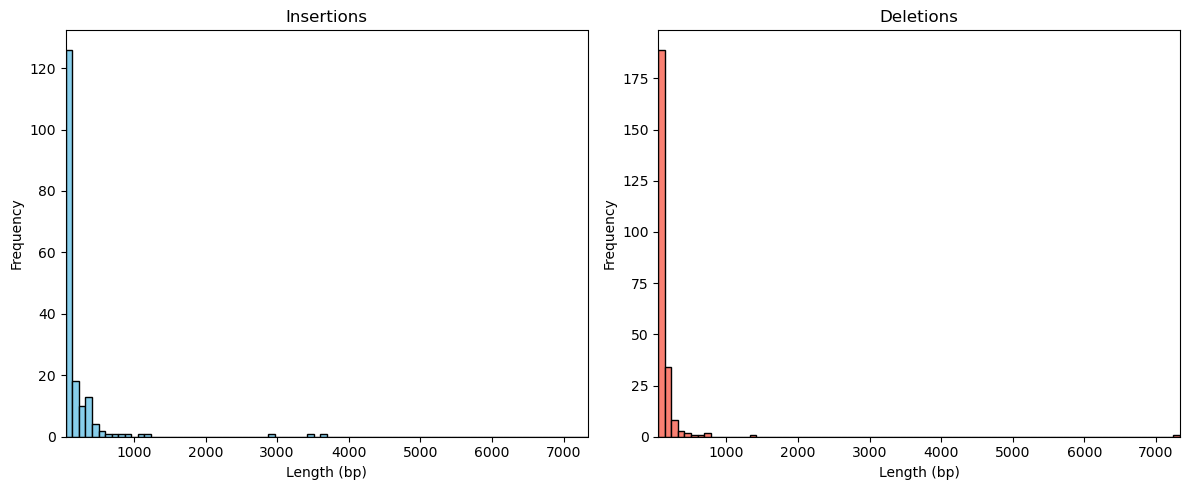

In [14]:

ins_data = np.array(vcf_data['INS']['lengths'])
del_data = np.array(vcf_data['DEL']['lengths'])

x_min = 50
x_max = max(ins_data.max(), del_data.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Insertion histogram
axes[0].hist(ins_data, bins=80, color='skyblue', edgecolor='black', range=(x_min, x_max))
axes[0].set_xlabel('Length (bp)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Insertions')
axes[0].set_xlim(x_min, x_max)  # force same x-axis

# Deletion histogram
axes[1].hist(del_data, bins=80, color='salmon', edgecolor='black', range=(x_min, x_max))
axes[1].set_xlabel('Length (bp)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Deletions')
axes[1].set_xlim(x_min, x_max)  # force same x-axis

plt.tight_layout()
plt.show()



### inspecting the log of the lengths

the lognormal distribution may be one of the best candidates, for this reason it's good to have a look a the log transformatinon of the lengths

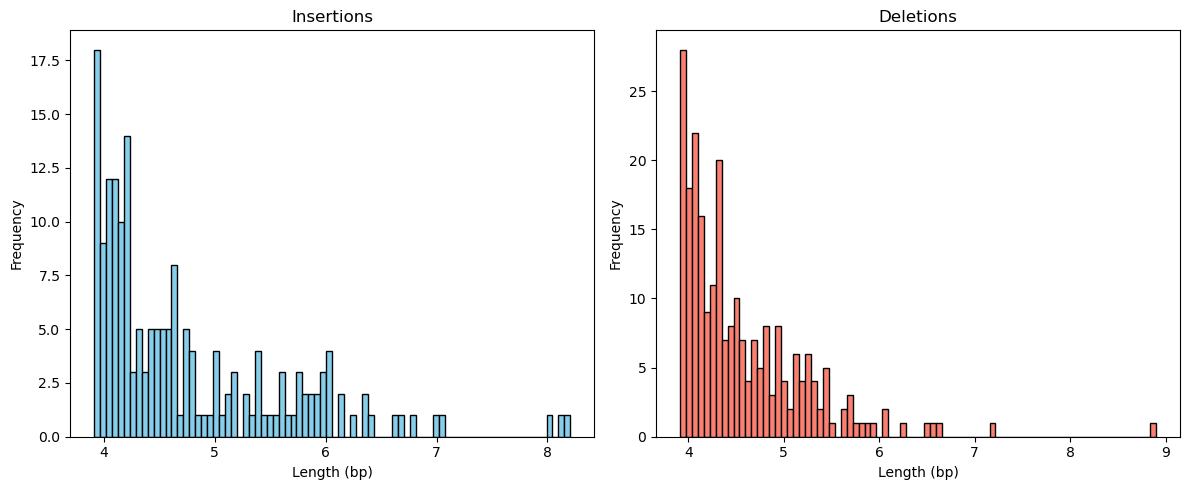

In [19]:

ins_data = np.log(np.array(vcf_data['INS']['lengths']))
del_data = np.log(np.array(vcf_data['DEL']['lengths']))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Insertion histogram
axes[0].hist(ins_data, bins=80, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Length (bp)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Insertions')


# Deletion histogram
axes[1].hist(del_data, bins=80, color='salmon', edgecolor='black')
axes[1].set_xlabel('Length (bp)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Deletions')


plt.tight_layout()
plt.show()


# fitting to different distributions

1. INS lengths fitting
2. DEL lengths fitting

In [22]:
distributions = ['gamma','lognorm','weibull_min','pareto']
fits = {}

for distr_name in distributions:
    distr = getattr(stats, distr_name)
    params = distr.fit(vcf_data['INS']['lengths'], floc=49)
    ll = np.sum(distr.logpdf(vcf_data['INS']['lengths'], *params))
    fits[distr_name] = (params, ll)

print(sorted(fits.items(), key= lambda x: x[1][1], reverse=True))

[('lognorm', ((1.7396172119233615, 49.0, 37.13264074995905), -1016.8522029984276)), ('weibull_min', ((0.5760362430336337, 49, 89.31926357039598), -1032.245709579831)), ('gamma', ((0.43821120623993903, 49, 372.1924468759423), -1049.5179852015358)), ('pareto', ((0.2766637154453428, 49, 1), -1073.6997036902183))]


In [21]:
for distr_name in distributions:
    distr = getattr(stats, distr_name)
    params = distr.fit(vcf_data['DEL']['lengths'], floc=49)
    ll = np.sum(distr.logpdf(vcf_data['DEL']['lengths'], *params))
    fits[distr_name] = (params, ll)

print(sorted(fits.items(), key= lambda x: x[1][1], reverse=True))


[('lognorm', ((1.5105921105556788, 49.0, 27.609604240236106), -1246.204149916995)), ('weibull_min', ((0.633257235418438, 49, 58.48602635899252), -1270.5919784838693)), ('gamma', ((0.49431587396429116, 49, 202.34995203826983), -1302.1248545020603)), ('pareto', ((0.3013715093193935, 49, 1), -1335.2532025077746))]


there are several considerations to be made here: 
1. what is best may not be what is best fitting my data
my purpose is mainly to create a realistic set of SV, but the end goal is always to focus on longer SVs. In my sample dataset, weibull and lognormal seem the best options as they best fit my data, however conceptually it makes a lot of sense to go with a heavy tailed distribution such as the pareto distribution, giving more emphasis on the longer SVs. 

2. if the fitting is done based on the input of a specific variant caller, there may be an overrepresentation of SV having a SVLEN that the variant caller is particularly good at catching.

it might be best to leave the user the maximum flexibility and allow him the choice of the distribution from which he wants to sample